In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/2025ML+DL Programming/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/2025ML+DL Programming/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras import models, layers

In [11]:
Hybrid_LSTM_CNN = models.Sequential([
    # 1️⃣ CNN 블록 (국소 패턴 추출)
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    # 2️⃣ LSTM 블록 (시계열 관계 학습)
    layers.LSTM(128, return_sequences=False),
    layers.Dropout(0.3),

    # 3️⃣ Dense 블록 (분류)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_outputs, activation='softmax')
])

# 컴파일
Hybrid_LSTM_CNN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Hybrid_LSTM_CNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,710 (627.77 KB)

 Trainable params: 160,710 (627.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = Hybrid_LSTM_CNN.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6028 - loss: 0.9777 - val_accuracy: 0.8727 - val_loss: 0.3276
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8867 - loss: 0.3079 - val_accuracy: 0.9389 - val_loss: 0.1724
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9361 - loss: 0.1781 - val_accuracy: 0.9559 - val_loss: 0.1147
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9448 - loss: 0.1458 - val_accuracy: 0.9559 - val_loss: 0.1207
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.1721 - val_accuracy: 0.9389 - val_loss: 0.1499
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9490 - loss: 0.1262 - val_accuracy: 0.9525 - val_loss: 0.1125
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9545 - loss: 0.1109 - val_accuracy: 0.9525 - val_loss: 0.1092
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9507 - loss: 0.1202 - val_accuracy: 0.9525 - v

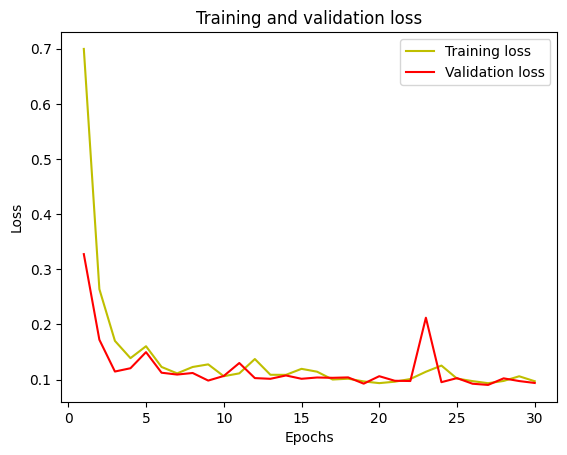

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

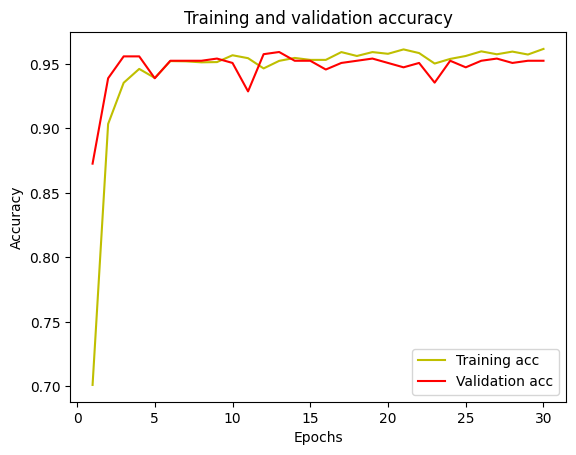

In [14]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[471  25   0   0   0   0]
 [  0 458  13   0   0   0]
 [  0   4 416   0   0   0]
 [  0   7   0 424  59   1]
 [  1   0   0 117 414   0]
 [  0   0   0   0   0 537]]
0.9229725144214456
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.93      0.97      0.95       471
           2       0.97      0.99      0.98       420
           3       0.78      0.86      0.82       491
           4       0.88      0.78      0.82       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

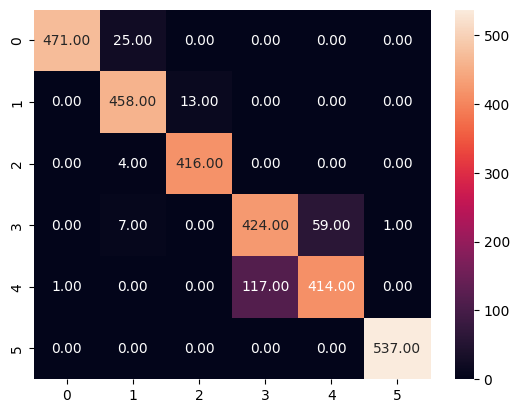

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=Hybrid_LSTM_CNN.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')